In [1]:
import argparse
from glob import glob
import tensorflow as tf
import time
from model import denoiser
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(epoch=10, batch_size=32, lr=0.001, use_gpu=1, phase='inference',ckpt_dir='./checkpoint', test_dir='./data/denoised',image_path='./shared/im2.png')


In [3]:
def denoiser_train(denoiser, lr):
        noisy_eval_files = glob('./data/train/noisy/*.png')
        noisy_eval_files = sorted(noisy_eval_files)
        eval_files = glob('./data/train/original/*.png')
        eval_files = sorted(eval_files)
        denoiser.train(eval_files, noisy_eval_files, batch_size=args.batch_size, ckpt_dir=args.ckpt_dir, epoch=args.epoch, lr=lr)



In [4]:

def denoiser_test(denoiser):

    noisy_eval_files = glob('./data/test/noisy/*.png')
#    n = [int(i) for i in map(lambda x: x.split('/')[-1].split('.png')[0], noisy_eval_files)]
#    noisy_eval_files = [x for (y, x) in sorted(zip(n, noisy_eval_files))]
    noisy_eval_files = sorted(noisy_eval_files)
    eval_files = glob('./data/test/original/*.png')
    eval_files = sorted(eval_files)
    start = time.time()
    denoiser.test(eval_files, noisy_eval_files, ckpt_dir=args.ckpt_dir, save_dir='./data/denoised')
    end = time.time()
    print "Elapsed time:", end-start

In [19]:
def increase_contrast(img):

    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final
    #_____END_____#

In [90]:
def denoiser_inference(denoiser, image_path):
    start = time.time()
    im1 = cv2.imread(image_path)
    im1 = cv2.resize(im1, (180,180)) 
    plt.imshow(im1)
    plt.show()
    im1 = increase_contrast(im1)
    im1 = cv2.blur(im1,(5,5))
    plt.imshow(im1)
    plt.show()
    denoised_image = denoiser.inference(im1,ckpt_dir=args.ckpt_dir)
    #denoised_image=np.array(denoised_image, dtype='uint8')
    print(np.amax(denoised_image))
    denoised_image = denoised_image/(np.amax(denoised_image)+1)
    print(np.amax(denoised_image))
    denoised_image=np.array((denoised_image*255.0), dtype='uint8')
    plt.imshow(denoised_image)
    plt.show()
    end = time.time()
    print "Elapsed time:", end-start

In [91]:
if not os.path.exists(args.ckpt_dir):
    os.makedirs(args.ckpt_dir)
if not os.path.exists(args.test_dir):
    os.makedirs(args.test_dir)

lr = args.lr * np.ones([args.epoch])
lr[30:] = lr[0] / 10.0

# added to control the gpu memory
print("GPU\n")


GPU



[*] Initialize model successfully...


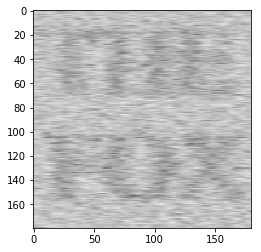

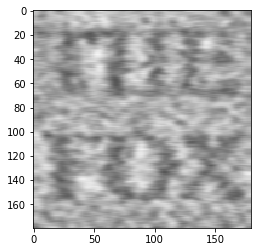

[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint/DnCNN-tensorflow-353500
 [*] Load weights SUCCESS...
(1, 180, 180, 3)
  Imread SUCCESS...
245.63948
0.9959455


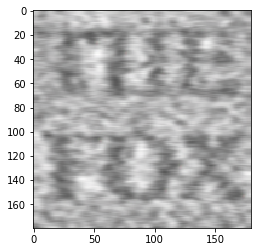

Elapsed time: 1.16941308975


In [92]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
image_path = './shared/im4.png'
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    model = denoiser(sess)
    if args.phase == 'train':
        denoiser_train(model, lr=lr)
    elif args.phase == 'test':
        denoiser_test(model)
    elif args.phase == 'inference':
        denoiser_inference(model,image_path)
    else:
        print('[!]Unknown phase')
        exit(0)
    

In [64]:
def test():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
      model = denoiser(sess)
      denoiser_test(model)

In [ ]:
run()